In [1]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import re
import seaborn as sns

## Setup & Basic info

In [2]:
PATH = os.path.join("..", "data", "raw", "Allegato 1 - data_classification.xlsx")

df = pd.read_excel(PATH)
df.head()

,Review,Promotore
0,Rooms are nice but for elderly a bit difficul...,0
1,My room was dirty and I was afraid to walk ba...,0
2,Cleaner did not change our sheet and duvet ev...,0
3,Good location Set in a lovely park friendly s...,1
4,Even though the pictures show very clean room...,0


In [3]:
print("Shape:", df.shape)
df.info()
df.describe(include='all')

Shape: (344671, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344671 entries, 0 to 344670
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Review     344671 non-null  object
 1   Promotore  344671 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 5.3+ MB


,Review,Promotore
count,344671,344671.000000
unique,339647,NaN
top,Room was very small,NaN
freq,44,NaN
mean,NaN,0.501644
std,NaN,0.499998
min,NaN,0.000000
25%,NaN,0.000000
50%,NaN,1.000000
75%,NaN,1.000000


## Label Analysis

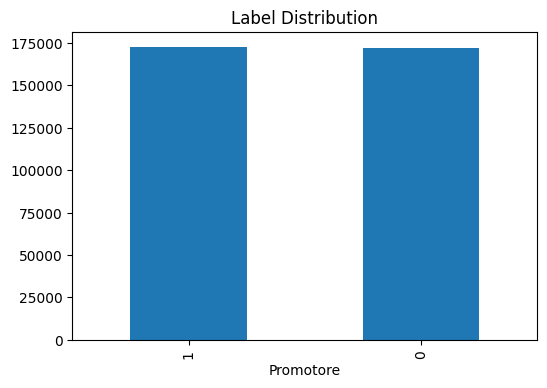

Promotore
1    0.501644
0    0.498356
Name: proportion, dtype: float64


In [4]:
text_col = "Review"
label_col = "Promotore"

df[label_col].value_counts().plot(kind='bar', figsize=(6,4), title="Label Distribution")
plt.show()

print(df[label_col].value_counts(normalize=True))

## Review Text Analysis

In [5]:
# Identify empty reviews (only whitespace or truly empty after stripping)
empty_reviews = df[df[text_col].astype(str).str.strip().eq("")]

# Identify very short reviews (fewer than 3 characters).
short_reviews = df[df[text_col].astype(str).str.len() < 3]

print("Empty reviews:", len(empty_reviews))
print("Short reviews:", len(short_reviews))

Empty reviews: 0
Short reviews: 0


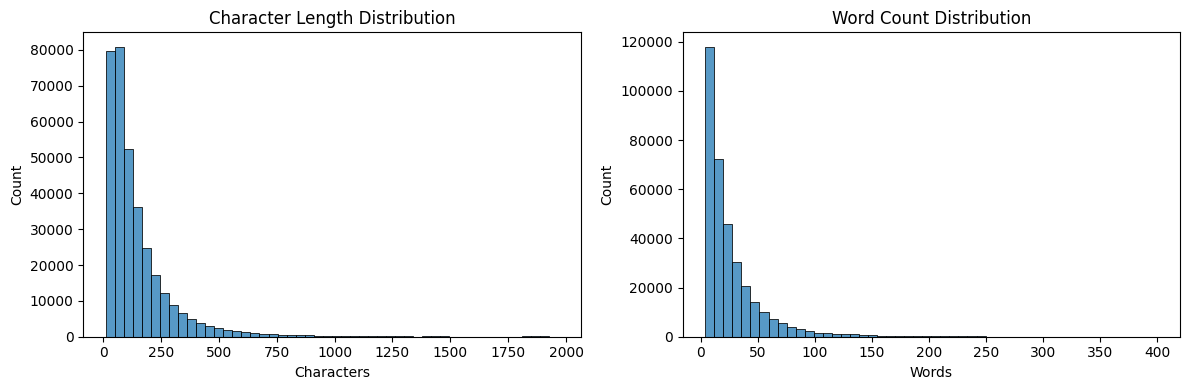

,char_len,word_len
count,344671.000000,344671.000000
mean,149.006328,27.359972
std,166.815328,32.280271
min,11.000000,4.000000
25%,53.000000,9.000000
50%,97.000000,17.000000
75%,180.000000,33.000000
max,1965.000000,400.000000


In [6]:
df["char_len"] = df[text_col].astype(str).str.len()
df["word_len"] = df[text_col].astype(str).str.split().str.len()

fig, ax = plt.subplots(1, 2, figsize=(12,4))

# Plot histogram of character lengths
sns.histplot(df["char_len"], bins=50, ax=ax[0])
ax[0].set_title("Character Length Distribution")
ax[0].set_xlabel("Characters")
ax[0].set_ylabel("Count")

# Plot histogram of word counts
sns.histplot(df["word_len"], bins=50, ax=ax[1])
ax[1].set_title("Word Count Distribution")
ax[1].set_xlabel("Words")
ax[1].set_ylabel("Count")

# Render the plots
plt.tight_layout()
plt.show()

# Show basic summary statistics for both length columns
df[["char_len", "word_len"]].describe()

In [7]:
# Display the 5 longest reviews by character length
df.nlargest(5, "char_len")[[text_col, "char_len"]]

,Review,char_len
1897,We booked this through a third party booking ...,1965
23056,Firstly it was very warm 21 degrees on 30 Mar...,1960
72043,I would just like to let you know what an ama...,1960
342686,The customer service was really bad On arriva...,1959
13693,Sadly this is where we felt the highlights en...,1958


In [8]:
df['review_length'] = df[text_col].str.len()

# Define the percentiles we want to inspect
percentiles = [0.75, 0.80, 0.90, 0.95, 0.99]

# Compute the quantile values for the specified percentiles
quantile_values = df['review_length'].quantile(percentiles)

# Print a compact table of percentile -> character length
print("--- Review Length Percentiles (Character Length) ---")
print(quantile_values)

# Print a more human-readable formatted output (rounded and shown as integers)
print("\nFormatted Output:")
for percentile, length in quantile_values.items():
	print(f"{int(percentile * 100):>2d}th Percentile: {int(round(length)):>4d} characters")

--- Review Length Percentiles (Character Length) ---
0.75    180.0
0.80    210.0
0.90    313.0
0.95    440.0
0.99    839.0
Name: review_length, dtype: float64

Formatted Output:
75th Percentile:  180 characters
80th Percentile:  210 characters
90th Percentile:  313 characters
95th Percentile:  440 characters
99th Percentile:  839 characters


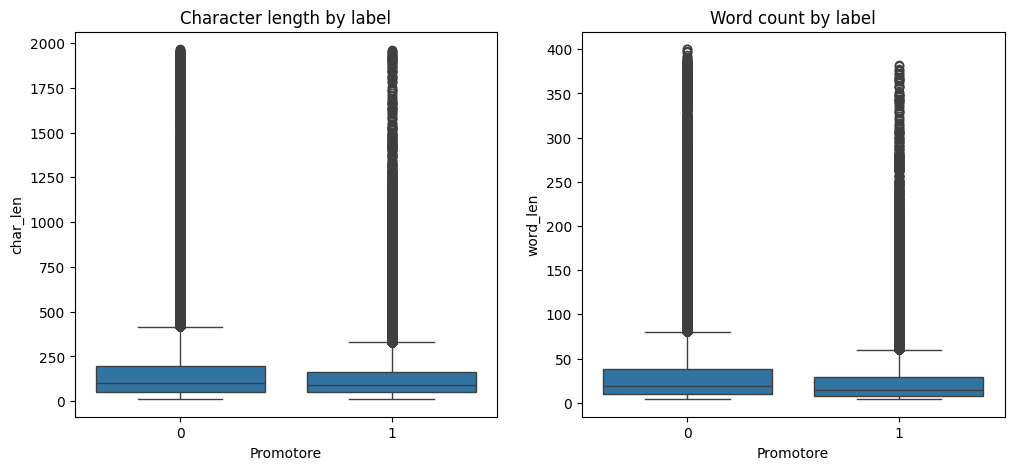

           char_len                                                            \
              count        mean         std   min   25%    50%    75%     max   
Promotore                                                                       
0          171769.0  165.001572  193.136941  11.0  54.0  103.0  199.0  1965.0   
1          172902.0  133.115898  133.822256  13.0  53.0   92.0  164.0  1960.0   

           word_len                                                      
              count       mean        std  min   25%   50%   75%    max  
Promotore                                                                
0          171769.0  31.522097  37.779791  4.0  10.0  19.0  38.0  400.0  
1          172902.0  23.225122  24.998862  4.0   8.0  15.0  29.0  382.0  


In [9]:
# Analyze length distributions by label to check for possible correlations
df["char_len"] = df[text_col].astype(str).str.len()
df["word_len"]  = df[text_col].astype(str).str.split().str.len()

fig, ax = plt.subplots(1, 2, figsize=(12,5))

sns.boxplot(data=df, x=label_col, y="char_len", ax=ax[0])
ax[0].set_title("Character length by label")

sns.boxplot(data=df, x=label_col, y="word_len", ax=ax[1])
ax[1].set_title("Word count by label")

plt.show()

print(df.groupby(label_col)[["char_len", "word_len"]].describe())

In [10]:
# Check for duplicate review texts
dups = df.duplicated(subset=[text_col], keep=False)
dups_df = df.loc[dups]
dups_counts = dups_df[text_col].value_counts()

print("--- Duplicate Review Text and Appearance Count ---")
print(dups_counts) 
print(f"\nTotal unique reviews that are duplicates: {len(dups_counts)}")
print(f"Total duplicate reviews: {dups.sum()}")

--- Duplicate Review Text and Appearance Count ---
Review
Room was very small                                                                                           44
Size of the room                                                                                              40
Very friendly and helpful staff                                                                               34
Room was very small                                                                                           31
The room was very small                                                                                       27
                                                                                                              ..
Excellent location 5 mins walk from the train station Clean and comfortable hotel Breakfast was good           2
Stayed twice in both cases AC did not work properly in March it wasn t a problem                               2
Wifi could be better Been in this hote

In [11]:
# Check for conflicting labels among duplicates
dup_groups = dups_df.groupby(text_col)

# Initialize counters
conflicting_review_count = 0  # Counts unique reviews (text strings) with conflicts
total_conflict_instances = 0  # Counts total rows involved in conflicts

# Iterate through each group and check for label diversity
for review, group in dup_groups:
    # Check if there is more than one unique label in the group
    if group[label_col].nunique() > 1:
        # Increment the count of unique conflicting reviews
        conflicting_review_count += 1
        
        # Add the size of the entire group (all duplicate instances) 
        # to the total conflict instances count
        total_conflict_instances += len(group)

print("--- Conflicting Label Analysis ---")
print(f"Number of Unique Reviews with Conflicting Labels: {conflicting_review_count}")
print(f"Total Data Rows Involved in Label Conflicts: {total_conflict_instances}")

--- Conflicting Label Analysis ---
Number of Unique Reviews with Conflicting Labels: 77
Total Data Rows Involved in Label Conflicts: 390


### Special Characters Presence

In [12]:
url_pattern = re.compile(r"http\S+|www\.\S+")
hashtag_pattern = re.compile(r"#\w+")
mention_pattern = re.compile(r"@\w+")
html_pattern = re.compile(r"<[^>]+>")
emoji_pattern = re.compile(
    "[" 
    "\U0001F600-\U0001F64F"  # emoticons
    "\U0001F300-\U0001F5FF"  # symbols & pictographs
    "\U0001F680-\U0001F6FF"  # transport & map symbols
    "\U0001F1E0-\U0001F1FF"  # flags
    "]+", 
    flags=re.UNICODE
)


In [13]:
def contains(pattern, text):
    if not isinstance(text, str): 
        return False
    return bool(pattern.search(text))

df["has_url"] = df[text_col].apply(lambda x: contains(url_pattern, x))
df["has_hashtag"] = df[text_col].apply(lambda x: contains(hashtag_pattern, x))
df["has_mention"] = df[text_col].apply(lambda x: contains(mention_pattern, x))
df["has_html"] = df[text_col].apply(lambda x: contains(html_pattern, x))
df["has_emoji"] = df[text_col].apply(lambda x: contains(emoji_pattern, x))
df["punct_ratio"] = df[text_col].astype(str).apply(
    lambda x: sum(1 for c in x if c in r"!?,.;:") / max(len(x), 1)
)

In [14]:
feature_cols = ["has_url", "has_hashtag", "has_mention", "has_html", "has_emoji"]

for col in feature_cols:
    print(f"{col}: {df[col].mean()*100:.2f}% of reviews")

has_url: 0.00% of reviews
has_hashtag: 0.00% of reviews
has_mention: 0.00% of reviews
has_html: 0.00% of reviews
has_emoji: 0.00% of reviews
